In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

In [10]:
df = pd.read_csv('../data/training_results.csv')
df

,Name,n_way,k_shot,n_class_additions,n_classes_start,algorithm,dataset,validation_query_accuracy_epoch,train_query_accuracy_step,train_quick_update_inner_accuracy_epoch,validation_quick_update_inner_accuracy_epoch
0,dark-pond-104,50,200,5,5,FSCL,flickr8k,0.490398,0.596,0.518816,0.527365
1,deft-monkey-109,10,50,1,2,FSCL,google_commands,0.426061,0.640,0.623913,0.466667
2,expert-firebrand-107,50,50,5,5,FSCL,flickr8k,0.529600,0.596,0.470909,0.528000
3,polar-disco-110,10,200,1,2,FSCL,google_commands,0.420000,0.500,0.363636,0.371429
4,misunderstood-sun-19,50,5,5,5,FSCL,flickr8k,0.717250,0.804,0.940787,0.942813
5,divine-galaxy-67,5,5,3,1,FSCL,google_commands,0.851160,0.960,0.927637,0.907489
6,lilac-frost-2,5,5,1,1,FSCL,flickr8k,0.833467,0.760,0.906426,0.905085
7,pretty-gorge-86,10,20,1,2,FSCL,google_commands,0.541429,0.760,0.796610,0.665476
8,polished-spaceship-50,10,5,1,2,OML,flickr8k,0.750123,0.760,NaN,NaN
9,graceful-bird-68,10,5,1,2,FSCL,google_commands,0.729118,0.900,0.916878,0.865294


/var/folders/20/tzn3lm1s1h9f4tshjwtkn9bc0000gn/T/ipykernel_3173/1867552060.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)


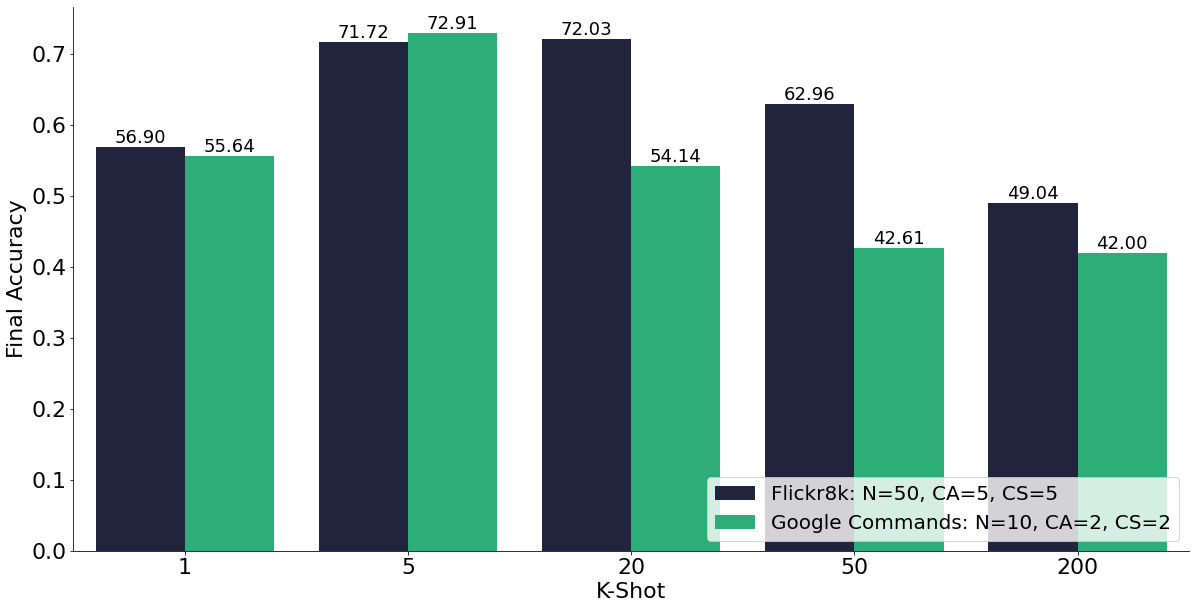

In [112]:
plot_df_1 = df[(df.n_way==50)&(df.n_class_additions==5)&(df.n_classes_start==5)&(df.algorithm=='FSCL')&(df.dataset=='flickr8k')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df_2 = df[(df.n_way==10)&(df.n_class_additions==1)&(df.n_classes_start==2)&(df.algorithm=='FSCL')&(df.dataset=='google_commands')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df = pd.concat([plot_df_1, plot_df_2])

def rename_(name):
    if name == 'flickr8k':
        return 'Flickr8k: N=50, CA=5, CS=5'
    else:
        return "Google Commands: N=10, CA=2, CS=2"

plot_df['dataset']=plot_df['dataset'].apply(rename_)
plot_df.rename(columns={'k_shot':'K-Shot', 'validation_query_accuracy_epoch':'Final Accuracy', 'dataset':'Dataset'}, inplace=True)

plt.figure(figsize=(20, 10))
# set colours allowed to use to certain hex value
sns.set_palette(sns.color_palette(["#1D2140", "#17C37B"])) 
sns.barplot(x='K-Shot', y='Final Accuracy', hue='Dataset', data=plot_df)
#add the value on top of the bar
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:1.2f}'.format(p.get_height()*100), fontsize=18, color='black', ha='center', va='bottom')

# make the legend text bigger
plt.legend(loc='lower right', prop={'size': 20})
# make plot font size bigger
plt.rcParams.update({'font.size': 22})

# remove top grid line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)
plt.show()

In [114]:
from src.models import WordClassificationAudio2DCnn, WordClassificationAudioCnnPool as WordClassificationAudioCnn, WordClassificationRnn
from src.losses import ClassificationLoss
from src.algorithms import FSCL, OML
from src.data.datasets import Flickr8kWordClassification, GoogleCommandsWordClassification
from src.data.samplers import SpokenWordTaskBatchSampler
from src.utils import flatten_dict

import torch.nn as nn
import torch

In [116]:
class FSCLModel(nn.Module):
    def __init__(self, encoder, embedding_dim, n_classes):
        super().__init__()

        self.encoder = encoder

        def return_classification_layer(embedding_dim):
            layer = nn.Linear(embedding_dim, 1)
            torch.nn.init.xavier_uniform(layer.weight, )
            layer = nn.Sequential(
                nn.ReLU(),
                layer
            )
            return layer

        layers = [return_classification_layer(embedding_dim) for _ in range(n_classes)]
        self.classifiers = nn.ModuleList(layers)

    def forward(self, audio, total_classes_present):
        features = self.encoder(audio)
        layer_logits = []
        for c_layer in range(total_classes_present):
            layer_logits.append(self.classifiers[c_layer](features))
        logits = torch.cat(layer_logits, dim=1)
        return {'logits':logits}

In [118]:
optim = {
'name': 'adam',
'inner_steps': 5,
'val_inner_steps': 5,
'gradient_clip_val': 0,
'inner_learning_rate': 0.001,
'outer_learning_rate': 0.0001,
'scheduler': False,
'scheduler_step': 30,
'scheduler_decay': 0.1,
}

In [124]:
encoder = WordClassificationAudio2DCnn(
    256, 
    64, 
    input_channels=39
)

loss_fn = ClassificationLoss()

model = FSCLModel(encoder, 256, 50)
algorithm = FSCL.load_from_checkpoint(
    './nway50_k5.ckpt', 
    model=model, 
    training_steps=5,
    intial_training_steps=30,
    n_classes_start=5,
    n_class_additions=5,
    loss_func=loss_fn,
    optim_config=optim,
    k_shot=5,
    quick_adapt=True
)

/var/folders/20/tzn3lm1s1h9f4tshjwtkn9bc0000gn/T/ipykernel_3173/153488424.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


In [135]:
model = algorithm.model


model(torch.randn(5, 39, 256), 5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x3072 and 1344x256)

In [146]:
import yaml

with open('../config/conversion_method/mfcc.yaml') as f:
    conv_config = yaml.safe_load(f) 

In [147]:


valiadation_dataset = Flickr8kWordClassification(
    meta_path='../data/flickr/flickr8k_word_splits_validation.csv',
    audio_root='../data/flickr/wavs/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False               
)

Loading audio: 100%|██████████| 32974/32974 [00:00<00:00, 765623.42it/s]


In [148]:
valiadation_dataset[0]

/Users/ruanvdmerwe/miniforge3/envs/fscl/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '../data/flickr/wavs/data/flickr/wavs/OTHER_3_4_1321723162_9d4c78b8af_3.wav'